__[Link to Orioles 2](https://www.safaribooksonline.com/oriole/probabilistic-programming-from-scratch-2-bayes-theorem-and-online-learning)__

### Approximate Bayesian Computation (ABC) 

- Understand in detail how the **ABC** algorithm relates to **Bayes' Theorem**
- Hear some straight talk about the gnashing of teeth around priors
- Learn how reimplementing ABC w/idiomatic Python + many generators = better code
- Watch how the reimplemented system handles data in the online setting

#### BAYES' THEOREM

$$Pr(H|D)∝Pr(H)Pr(D|H)$$

* Our beliefs before the experiment (Pr(H)), the **prior** $$ Pr(H) $$
* Our beliefs after an experiment (that's Pr(H|D)), the **posterior**  $$  Pr(H|D)$$
* And the data is consistent with those beliefs (Pr(D|H)), the **likelihood** $$Pr(D|H)$$

>**H** is a particular hypothesis. In the context of an **A/B test**, that might be a particular belief about the conversion fraction; so "layout A's conversion fraction is 2.42%" is a hypothesis. And D is the data, i.e. the results of our A/B test.

 The prior
=====
>Let's start on the right. Pr(H) is the probability a hypothesis was true before you conducted the experiment, is the prior probability. In ABC, that directly correspondes to the function that generates trial values.

The likelihood
=============

>Pr(D|H), the probability that you would get the observed data if the hypothesis were true, is the likelihood. If you take the formal mathematical approach to Bayesian inference, this is a tricky thing to evaluate exactly. In ABC we avoid all the complexity by simply running simulations and rejecting ones that didn't work out. But the idea is the same.

The posterior
==

>On the left, we've got the end game of all this. P(H|D) is the probability a hypothesis is true given the data. This is properly known as posterior probability. Generally speaking, this is the thing you need to know! It's what your beliefs about the world are after the experiment. It's the thing you use to answer a question like "should I switch from layout A to layout B?

<div class="alert alert-block alert-success"> REIMPLEMENTING ABC WITH GENERATORS </div>

>ABC in a more idiomatically Pythonic and functional style

In [9]:
def abayes(data, prior_sampler, simulate, compare):
    '''Yield samples from the posterior by Approximate Bayesian Computation.'''
    for p in prior_sampler:
        if compare(simulate(p), data):
            yield p

__data__ 
> is the observation. This is the thing we're going to compare the outcome of the simulation to (remember the ABC algorithm).

__prior_sampler__
>is more complicated than it might at first look, but it's basically a sequence of trial values, or samples from the prior distribution of our beliefs.

__simulate__
> is the <u>callable function </u> that is used to simulate the experiment; 

__compare__
> is the callable function that will compare the simulated outcome to the data.

__abayes__ works by iterating over the prior samples, and running compare on the output of simulate and the data. If they agree, it _yield_s the prior sample.

__prior_sampler__ is a generator, and the yield statement tells you __abayes__ itself is also a generator.

>>A __generator__ is in essence an ordered sequence, like a list, but with two crucial differences. Firstly, a generator yields up items one at a time. For large sequences, or for pipelines with lots of intermediate steps, this is an important advantage. Secondly, their length is undetermined. They can potentially yield up items forever.

__prior_sampler__ needs to be a generator that yields up a stream of trial values of the thing we want to know. It has prior in the name because that's what it is: a function that samples from the prior distribution Pr(H) that we mentioned
above.

The for loop in __abayes__ iterates over the __prior_sampler__, running the ABC algorithm (simulate the observation, compare it to the real thing) and yields each prior sample that works out. These are samples from the posterior, so another name for the abayes generator could be __posterior_sampler__.

In [10]:
n_visitors_a = 100  # number of visitors shown layout A
n_conv_a = 4        # number of vistors shown layout A who converted (4%)

n_visitors_b = 40  
n_conv_b = 2

In [11]:
def compare_conversion(sim, obs):
    '''Return True if two observations are the same.'''
    return sim == obs

compare_conversion(42, 42),compare_conversion(42, 99)

(True, False)

In [12]:
import random

def simulate_conversion(p, n_visitors):
    '''Returns number of vistors who convert given conversion fraction p.'''
    # This used to be "outcomes = [random.random() < p for _ in range(nvisitors)]"
    outcomes = (random.random() < p for _ in range(n_visitors)) # Generator comprehension, sequesnce does not exist in memory
    return sum(outcomes)

> By using parentheses instead of square brackets we've made a generator comprehension. 
>> before sum is called, none of the calls to random.random have happend yet. outcomes is pregnant with possibility, but until we consume the generator, none of the work is done. This is __lazy evaluation__.

In [13]:
def uniform_prior_sampler():
    '''Yield random numbers in interval (0, 1).'''
    while True:
        yield random.random()

> __prior_sampler__
>> uniform prior for layout A --> no idea what it's conversion fraction is, so we'll try anything from 0 to 1 --> generator that returns a potentially infinite stream of trial values.

> What if we want to take a look at a few values? We have at least a couple of options. We can call next to get the next value.

In [14]:
gen = uniform_prior_sampler()
print(next(gen))
print(next(gen))

0.06364500819599028
0.6305800455764367


>Or we can use __islice__ from the __itertools__ library to truncate the generator, then consume that truncated generator with list.

In [15]:
import itertools

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(itertools.islice(iterable, n))

In [16]:
take(3, gen)

[0.4244643937428002, 0.8417230269116721, 0.9005508036149362]

<div class="alert alert-block alert-warning"> Now we're ready to run abayes. </div>

```python 

def abayes(data, prior_sampler, simulate, compare):
    '''Yield samples from the posterior by Approximate Bayesian Computation.'''
    for p in prior_sampler:
        if compare(simulate(p), data):
            yield p

```

In [17]:
posterior_a_sampler = abayes(data=n_conv_a,prior_sampler=uniform_prior_sampler(), 
                             simulate=lambda p: simulate_conversion(p, n_visitors_a),
                             compare=compare_conversion)

>> Let's do that by running take on the generator. In mathematical terms, this corresponds exactly to drawing 5 samples from the posterior for layout A.

In [18]:
take(5, posterior_a_sampler)

[0.04976992812654546,
 0.042298445756784764,
 0.042315422114291956,
 0.037667502412302656,
 0.043302428474556676]

>> From the posterior of layout B sampler. We have prior beliefs about layout B. Concretely, we suspect the conversion fraction is around 6% before we run the experiment; so we need a new __prior_sampler__.

In [19]:
def normal_prior_sampler(mu=0.06, sigma=0.02):
    '''Yield stream of samples from normal distribution in interval (0, 1).'''
    while True:
        x = random.normalvariate(mu, sigma)
        if 0 <= x <= 1:
            yield x

> Note that we check that potential values are between 0 and 1. That's because we know for a logical certainty that a conversion fraction cannot be outside that range. In mathematical terms this is known as constraining the support of a distribution.

In [20]:
posterior_b_sampler = abayes(
    data=n_conv_b,
    prior_sampler=normal_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, n_visitors_b),
    compare=compare_conversion)

>> Finally, let's ask for 5000 samples from each.



In [21]:
nsamples = 5000
a_samples = take(nsamples, posterior_a_sampler)
b_samples = take(nsamples, posterior_b_sampler)


> Now let's plot the results.

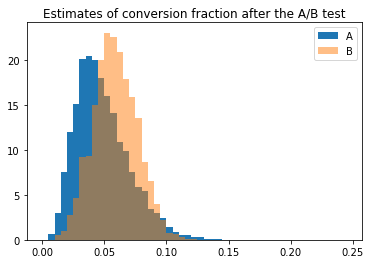

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

abbins = [i/200.0 for i in range(50)]  # 50 bins between 0 and 0.25
plt.hist(a_samples, bins=abbins, label='A', normed=True)
plt.hist(b_samples, bins=abbins, label='B', alpha=0.5, normed=True)
plt.title('Estimates of conversion fraction after the A/B test')
plt.legend();

> These are the __posterior__ distributions which describe our beliefs about layout A and B. As we saw in the previous part of this series, we can use them to answer questions like 
>> "what's the probability layout __B__ is better than layout __A__?".

In [25]:
b_better = [b > a for a, b in zip(a_samples, b_samples)]
Prob=sum(b_better)/len(a_samples)
print('\n \n The Probability that Layout B is better = {} \n \n'.format(Prob))


switch_b= [(b-a)/a >=.20 for a, b in zip(a_samples, b_samples)]
Prob=sum(switch_b)/len(a_samples)

print('\n \n The Probability that Layout B 20% better than A = {} \n \n'.format(Prob))

                  
                  


 
 The Probability that Layout B is better = 0.6576 
 


 
 The Probability that Layout B 20% better than A = 0.5286 
 



***
### ONLINE LEARNING
***

> First, let's be explicit about what we've used ABC to do. We've turned beliefs _prior_ to an experiment into beliefs after an experiment, the _posterior_.

> Bayesians sometimes say "today's posterior is tomorrow's prior". What they mean is, if we then go on to do another experiement, we can use the posterior from the previous experiement as a new prior.

In [27]:
conversions = [1, 0, 2, 0, 1]  # every 20 visitors and add up to 4%

> instead of being given the final results of the performance of layout A after 100 visitors, we were given the results every 20 visitors.

* Now we can use our abayes function to set up an __"online" experiment__ that learns from new data as it arrives, and gives us a live picture of our beliefs.

* We do this by writing a generator that yields up the posterior after an observation, and then uses that posterior as the prior for the next round.

In [28]:
def online_abayes(datas, prior_sampler, simulate, compare, nsamples=10000):
    '''Yield nsamples from the posterior for each observation in datas.'''
    for data in datas:
        posterior_samples = take(nsamples, abayes(data, prior_sampler, simulate, compare))
        yield posterior_samples
        prior_samples = posterior_samples
        prior_sampler = sampler_from_samples(prior_samples)

>> This generator very literally encodes the idea that "today's posterior is tomorrow's prior" in the penultimate line.

> For each data point in datas, it runs ABC, yields the posterior samples, then updates the prior.

>> The function sampler_from_samples takes a list of samples and turns it into an infinite generator, which is what abayes needs on the next iteration.

In [29]:
def sampler_from_samples(samples):
    '''
    Returns a generator that yields a shuffled repeating 
    sequence of items from the finite iterable samples.
    '''
    samples = list(samples)
    random.sample(samples, len(samples))
    return itertools.cycle(samples)

>> Now we can set up a generator that yields a large number of samples from the posterior after each batch of 20 visitors.

In [30]:
posteriors = online_abayes(
    datas=conversions,
    prior_sampler=uniform_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, 20),
    compare=compare_conversion)

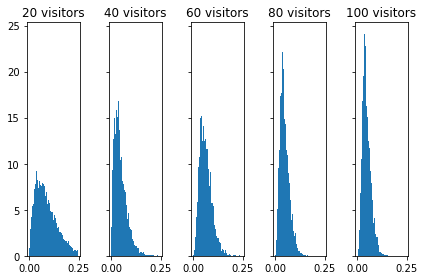

In [31]:
fig, ax = plt.subplots(1, len(conversions), sharey=True)
for i, p in enumerate(posteriors):
    ax[i].hist(p, bins=abbins, normed=True)
    ax[i].set_title('{} visitors'.format((i+1)*20))
fig.tight_layout()

> Note that the posterior distribution gets narrower and more concentrated as we collect more visitors. This means we're becoming more confident, which makes sense.

> The end result after 100 visitors is the same as what we had before, but the online approach allows us to make quantitative statements much earlier on. We can stop the experiment the minute we become confident enough for our use case.

> And equally importantly: it allows us to smoothly transition from a reigime in which we're depending on our best guess (the prior), to one where our beliefs are dominated by data. This is useful when you're bootstrapping a product that depends on data that you don't yet have, perhaps because you don't have any users

>  then reimplemented ABC using idiomatic Python, and in particular, lots of generators. We saw how these sequences, that are lazily evaluated and of potentially infinite length, can make code more concise and also more general.

>> in our approach, we become increasingly less sensitive to the prior the more data we have. If you don't like priors, get more data.

In [34]:
#Number of data per user 20 --> 100

conversions = [5, 0, 10, 0, 5]  # every 20 visitors and add up to 4%
posteriors = online_abayes(
    datas=conversions,
    prior_sampler=uniform_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, 100),
    compare=compare_conversion)

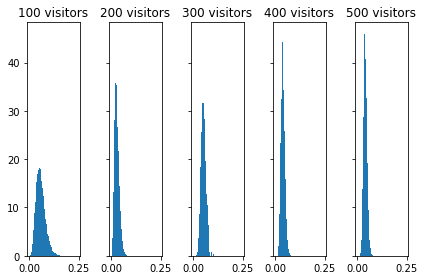

In [35]:
fig, ax = plt.subplots(1, len(conversions), sharey=True)
for i, p in enumerate(posteriors):
    ax[i].hist(p, bins=abbins, normed=True)
    ax[i].set_title('{} visitors'.format((i+1)*100))
fig.tight_layout()